In [2]:
"""
Linear Laplace equation with nonhomogeneous Dirichlet boundary condition.
"""

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
"""
Number of inputs and outputs: #inputs = 2 (x,y); #outputs = 1 (u)

This NN has 5 hidden layer with 10 neurons each
"""
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.hidden_layer1 = nn.Linear(2,10)
        self.hidden_layer2 = nn.Linear(10,10)
        self.hidden_layer3 = nn.Linear(10,10)
        self.hidden_layer4 = nn.Linear(10,10)
        self.hidden_layer5 = nn.Linear(10,10)
        self.output_layer = nn.Linear(10,1)

    def forward(self,x,y):
        inputs = torch.cat([x,y],axis=1)
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output
        

In [4]:
# Create a nn model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

In [5]:
# Coefficient
def coef(x,y):
    r2 = x**2 + y**2
    internal_idx = (r2<=0.5*0.5)
    out_idx = (r2>0.5*0.5)
    r2[internal_idx] = 20
    r2[out_idx] = 1
    return r2

In [6]:
# The linear Laplace equation
def f(x,y,net):
    a = coef(x,y)
    u = net(x,y)
    a_x = torch.autograd.grad(a.sum(), x, create_graph=True)[0]
    a_y = torch.autograd.grad(a.sum(), y, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]
    pde = a_x * u_x + a_y * u_y + a*(u_xx + u_yy) + 1
    return pde

In [7]:
def boundary_points(nb = 50):
    '''
    nb: number of points along each boundary
    '''
    x_bc,y_bc,u_bc = np.zeros((nb*4,1)),np.zeros((nb*4,1)),np.zeros((nb*4,1))
    interval = 2/nb
    
    # all boundaries are prescribed as 0
    # top
    x_bc[0*nb:(0+1)*nb,0] = np.linspace(-1+interval/2,1-interval/2,nb)
    y_bc[0*nb:(0+1)*nb,0] = np.full((nb,),1) # y coordinate
    # bottom
    x_bc[(0+1)*nb:(0+2)*nb,0] = np.linspace(-1+interval/2,1-interval/2,nb)
    y_bc[(0+1)*nb:(0+2)*nb,0] = np.full((nb,),-1) # y coordinate
    # left
    x_bc[(0+2)*nb:(0+3)*nb,0] = np.full((nb,),-1) # x coordinate
    y_bc[(0+2)*nb:(0+3)*nb,0] = np.linspace(-1+interval/2,1-interval/2,nb)
    # right
    x_bc[(0+3)*nb:(0+4)*nb,0] = np.full((nb,),1) # x coordinate
    y_bc[(0+3)*nb:(0+4)*nb,0] = np.linspace(-1+interval/2,1-interval/2,nb)
    return x_bc,y_bc,u_bc

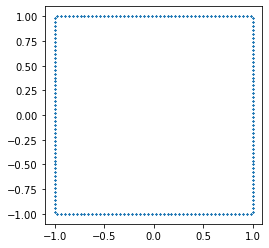

In [8]:
# obtain training data from boundary conditions
# boundary condition: all boundaries = 0
x_bc,y_bc,u_bc = boundary_points()

# plot boundary points
plt.Figure()
plt.scatter(x_bc,y_bc,s=2,marker="x")
axes=plt.gca()
axes.set_aspect(1)

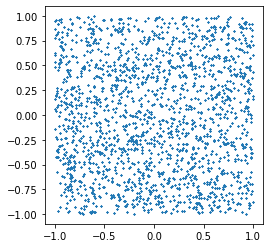

In [9]:
# Plot collocation point distribution
x_collocation = np.random.uniform(low=-1, high=1, size=(1800,1))
y_collocation = np.random.uniform(low=-1, high=1, size=(1800,1))
plt.Figure()
plt.scatter(x_collocation,y_collocation,s=2,marker="x")
axes=plt.gca()
axes.set_aspect(1)

In [10]:
# actural training of the nn model
iterations = 20000
previous_validation_loss = 99999999.0
loss_data = []
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # loss based on initial boundary conditions
    pt_x_ibc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_y_ibc = Variable(torch.from_numpy(y_bc).float(), requires_grad=False).to(device)
    pt_u_ibc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)

    net_bc_out = net(pt_x_ibc,pt_y_ibc)
    mse_u = mse_cost_function(net_bc_out,pt_u_ibc)

    # loss based on PDE
    x_collocation = np.random.uniform(low=-1, high=1, size=(1800,1))
    y_collocation = np.random.uniform(low=-1, high=1, size=(1800,1))
    all_zeros = np.zeros((1800,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_y_collocation = Variable(torch.from_numpy(y_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation,pt_y_collocation,net)
    mse_f = mse_cost_function(f_out,pt_all_zeros)

    # combining the loss function
    loss = mse_u + mse_f

    loss.backward() # computing gradients using backward propagation
    optimizer.step()

    with torch.autograd.no_grad():
        print(epoch,"Training Loss:",loss.data)
        loss_data.append(loss.data.item())

0 Training Loss: tensor(1.0666)
1 Training Loss: tensor(1.0623)
2 Training Loss: tensor(1.0580)
3 Training Loss: tensor(1.0539)
4 Training Loss: tensor(1.0500)
5 Training Loss: tensor(1.0462)
6 Training Loss: tensor(1.0426)
7 Training Loss: tensor(1.0392)
8 Training Loss: tensor(1.0359)
9 Training Loss: tensor(1.0328)
10 Training Loss: tensor(1.0298)
11 Training Loss: tensor(1.0270)
12 Training Loss: tensor(1.0244)
13 Training Loss: tensor(1.0219)
14 Training Loss: tensor(1.0196)
15 Training Loss: tensor(1.0174)
16 Training Loss: tensor(1.0154)
17 Training Loss: tensor(1.0136)
18 Training Loss: tensor(1.0119)
19 Training Loss: tensor(1.0103)
20 Training Loss: tensor(1.0089)
21 Training Loss: tensor(1.0076)
22 Training Loss: tensor(1.0065)
23 Training Loss: tensor(1.0054)
24 Training Loss: tensor(1.0045)
25 Training Loss: tensor(1.0037)
26 Training Loss: tensor(1.0030)
27 Training Loss: tensor(1.0024)
28 Training Loss: tensor(1.0019)
29 Training Loss: tensor(1.0014)
30 Training Loss: te

Text(0, 0.5, 'Loss')

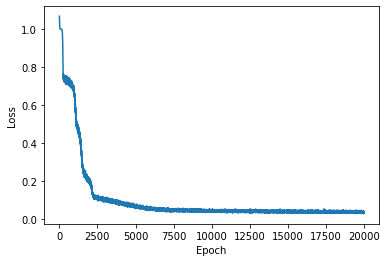

In [11]:
plt.plot(loss_data)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [18]:
# Save the data
with open('pinn_loss.npy', 'wb') as f:
    np.save(f, np.array(loss_data))

In [12]:
# Save Model
torch.save(net.state_dict(), "laplace_model.pt")

In [13]:
# Load model
net = Net()
net.load_state_dict(torch.load("laplace_model.pt"))
net.eval()

Net(
  (hidden_layer1): Linear(in_features=2, out_features=10, bias=True)
  (hidden_layer2): Linear(in_features=10, out_features=10, bias=True)
  (hidden_layer3): Linear(in_features=10, out_features=10, bias=True)
  (hidden_layer4): Linear(in_features=10, out_features=10, bias=True)
  (hidden_layer5): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

In [14]:
x = np.arange(-1,1,0.01)
y = np.arange(-1,1,0.01)
ms_x, ms_y = np.meshgrid(x,y)
x = np.ravel(ms_x).reshape(-1,1)
y = np.ravel(ms_y).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_y = Variable(torch.from_numpy(y).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_y)
u = pt_u.data.cpu().numpy()
ms_uu = u.reshape(ms_x.shape)

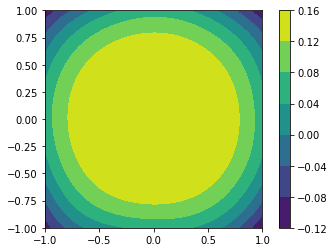

In [15]:
fig = plt.figure()
plt.contourf(np.arange(-1,1,0.01),np.arange(-1,1,0.01),ms_uu)
plt.axis('scaled')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.colorbar()

In [16]:
import meshio
from scipy.spatial import Delaunay

# two triangles and one quad
points = np.concatenate((x,y),axis=1)
points_connection = Delaunay(points)
cells = [("triangle", points_connection.simplices)]

mesh = meshio.Mesh(
    points,
    cells,
    point_data={"u": u},
)
mesh.write(
    "laplace.vtk", 
)

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.